✅ Cell 1：依赖 + 全局配置 + 公共函数

# codes

/var/folders/79/yd907p9x4537vqhgfrm0md680000gn/T/ipykernel_56970/3805671278.py:49: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bg = pd.read_csv(p, sep="\t", compression="gzip")
/var/folders/79/yd907p9x4537vqhgfrm0md680000gn/T/ipykernel_56970/3805671278.py:61: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bg = pd.read_csv(p, sep="\t", compression="gzip")


Summary 已保存： offtarget_results/summary_offtarget_counts.tsv
                    sample  n_offtarget_sites  median_offtarget_ratio  \
0       AIM_A_Max_IDR_rep1               5347                0.100775   
3      CP26_AIM_A_Max_rep1               3883                0.103448   
2  CP26_AIM_A_Max_IDR_rep1               3523                0.105691   
1           AIM_A_Max_rep1               3095                0.097087   

   mean_offtarget_ratio  total_sites_after_filters  
0              0.156208                    2144983  
3              0.161357                    1751613  
2              0.166767                    1381804  
1              0.153541                    1621537  


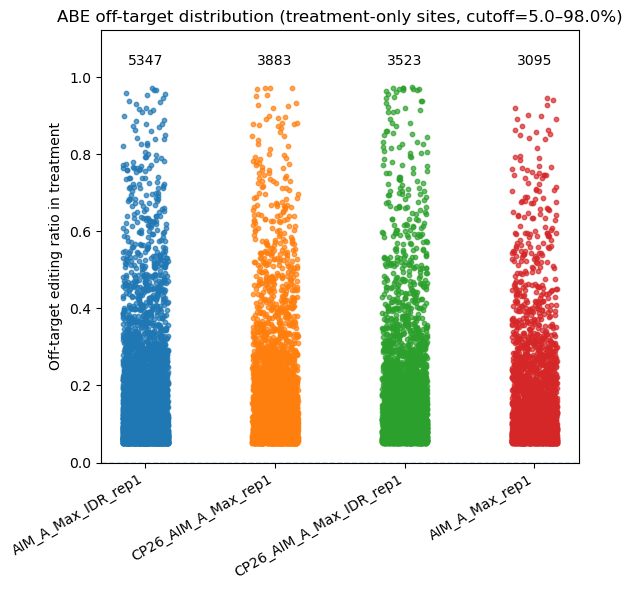

图已保存： offtarget_results/offtarget_jitterplot.png


In [14]:
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# =========================
# 配置
# =========================

DATA_DIR = Path("../results_RNA-seq/mut_tables")
OUT_DIR = Path("./offtarget_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

control_group = [
    "Control_rep1",
    "Control_rep2",
]

treatment_group = [
    "AIM_A_Max_IDR_rep1",
    "AIM_A_Max_rep1",
    "CP26_AIM_A_Max_IDR_rep1",
    "CP26_AIM_A_Max_rep1",
]

COVERAGE_MIN = 100  # coverage 下限

# 脱靶调用阈值：现在作用在 treatment 的 mut_ratio（不再做差值）
OFFTARGET_LOWER = 0.05
OFFTARGET_UPPER = 0.98

# HET 区间（作用在原始 treatment mut_ratio 上）
TREAT_HET_LOW = 0.497
TREAT_HET_HIGH = 0.503

BG_293T_PATH = Path("./bg_sites_293T.hg38.tsv.gz")
BG_GATK_PATH = Path("./bg_sites_GATKbundle.hg38.tsv.gz")

# =========================
# 1. 构建背景位点 MultiIndex (chr_name, chr_index)
# =========================

bg_indexes = []

# 293T 背景
p = BG_293T_PATH
df_bg = pd.read_csv(p, sep="\t", compression="gzip")
df_bg["chr"] = df_bg["chr"].astype(str)
df_bg["pos"] = df_bg["pos"].astype(int)
df_bg["chr_name"] = np.where(
    df_bg["chr"].str.startswith("chr"), df_bg["chr"], "chr" + df_bg["chr"]
)
df_bg["chr_index"] = df_bg["pos"].astype(int)
idx_bg = pd.MultiIndex.from_frame(df_bg[["chr_name", "chr_index"]])
bg_indexes.append(idx_bg)

# GATK 背景
p = BG_GATK_PATH
df_bg = pd.read_csv(p, sep="\t", compression="gzip")
df_bg["chr"] = df_bg["chr"].astype(str)
df_bg["pos"] = df_bg["pos"].astype(int)
df_bg["chr_name"] = np.where(
    df_bg["chr"].str.startswith("chr"), df_bg["chr"], "chr" + df_bg["chr"]
)
df_bg["chr_index"] = df_bg["pos"].astype(int)
idx_bg = pd.MultiIndex.from_frame(df_bg[["chr_name", "chr_index"]])
bg_indexes.append(idx_bg)

# 合并多个背景集合
bg_index = bg_indexes[0]
for idx_bg in bg_indexes[1:]:
    bg_index = bg_index.union(idx_bg)

# =========================
# 2. 读取所有 sample，做 ABE + 背景过滤 + coverage + mut_ratio
# =========================

core_tables = {}

for sample in control_group + treatment_group:
    in_path = DATA_DIR / f"{sample}.base_mut.filtered.tsv"
    df = pd.read_csv(in_path, sep="\t", dtype={"chr_name": str, "chr_index": int})

    # 去非核染色体
    df["chr_name"] = df["chr_name"].astype(str)
    mask_nuclear = ~df["chr_name"].str.match(r"^(chr)?(M|MT|Un|EBV)", case=False)
    df = df[mask_nuclear].copy()

    # ABE 定向：ref = A/T，mut_num 用 G/C
    mask_A = df["ref_base"] == "A"
    mask_T = df["ref_base"] == "T"
    df.loc[mask_A, "mut_num"] = df.loc[mask_A, "G"]  # A→G
    df.loc[mask_T, "mut_num"] = df.loc[mask_T, "C"]  # T→C
    df = df[mask_A | mask_T].copy()

    # 背景 SNP 过滤
    idx_tmp = pd.MultiIndex.from_frame(df[["chr_name", "chr_index"]])
    mask_keep = ~idx_tmp.isin(bg_index)
    df = df.loc[mask_keep].copy()

    # coverage + mut_ratio
    df["coverage"] = df[["A", "G", "C", "T", "del_count", "insert_count"]].sum(axis=1)
    df = df[df["coverage"] >= COVERAGE_MIN].copy()
    df = df[df["coverage"] > 0].copy()
    df["mut_ratio"] = df["mut_num"] / df["coverage"]

    core = df[["chr_name", "chr_index", "coverage", "mut_ratio"]].copy()
    core = core.set_index(["chr_name", "chr_index"]).sort_index()
    core_tables[sample] = core

control_core = OrderedDict((s, core_tables[s]) for s in control_group)
treat_core = OrderedDict((s, core_tables[s]) for s in treatment_group)

# =========================
# 3. Control 中“涉及过的位点”并集（mut_ratio > 0）
#    ——后面会把这些位点在 treatment 里全部丢掉
# =========================

control_any_idx = None
for s, core in control_core.items():
    idx_nonzero = core[core["mut_ratio"] > 0].index
    if control_any_idx is None:
        control_any_idx = idx_nonzero
    else:
        control_any_idx = control_any_idx.union(idx_nonzero)

# =========================
# 4. Treatment：先去 HET，再丢掉所有在 control 中出现过的位点
# =========================

treat_tables = OrderedDict()
for s, core in treat_core.items():
    tf = core.copy()

    # 去 HET 区间
    tf = tf[
        ~((tf["mut_ratio"] >= TREAT_HET_LOW) & (tf["mut_ratio"] <= TREAT_HET_HIGH))
    ].copy()

    # 丢掉所有 control 涉及的点
    if control_any_idx is not None:
        tf = tf[~tf.index.isin(control_any_idx)].copy()

    treat_tables[s] = tf

# =========================
# 5. union_idx = 所有 Treatment 的并集（treatment-only 位点）
# =========================

union_idx = None
for s, df_t in treat_tables.items():
    if union_idx is None:
        union_idx = df_t.index
    else:
        union_idx = union_idx.union(df_t.index)

if union_idx is None or len(union_idx) == 0:
    raise RuntimeError("所有 treatment 过滤后 union_idx 为空，请检查处理流程和阈值。")

# =========================
# 6. control_max 背景表（仅用于画图左侧背景分布）
#    由于对应位点都不在 control 中出现，理论上这里全是 0
# =========================

bg_max = pd.Series(0.0, index=union_idx, dtype=float)
for s, core in control_core.items():
    series = core.reindex(union_idx)["mut_ratio"].fillna(0.0)
    bg_max = pd.Series(
        np.maximum(bg_max.to_numpy(), series.to_numpy()), index=union_idx
    )

bg_df = pd.DataFrame({"bg_max_ratio": bg_max}, index=union_idx)

# =========================
# 7. offtarget_ratio：直接用 treatment 的 mut_ratio
# =========================

offtarget_tables = OrderedDict()
summary_rows = []

for s, tdf in treat_tables.items():
    idx_s = tdf.index
    t_use = tdf["mut_ratio"].to_numpy()
    bg_use = bg_df.reindex(idx_s)["bg_max_ratio"].fillna(0.0).to_numpy()

    offt = tdf["mut_ratio"].to_numpy()  # 核心：不再做差值

    merged = pd.DataFrame(
        {
            "mut_ratio": t_use,
            "bg_max_ratio": bg_use,
            "offtarget_ratio": offt,
        },
        index=idx_s,
    )

    call_mask = (merged["offtarget_ratio"] >= OFFTARGET_LOWER) & (
        merged["offtarget_ratio"] <= OFFTARGET_UPPER
    )

    offtarget_tables[s] = merged

    npos = int(call_mask.sum())
    summary_rows.append(
        {
            "sample": s,
            "n_offtarget_sites": npos,
            "median_offtarget_ratio": (
                float(merged.loc[call_mask, "offtarget_ratio"].median())
                if npos > 0
                else 0.0
            ),
            "mean_offtarget_ratio": (
                float(merged.loc[call_mask, "offtarget_ratio"].mean())
                if npos > 0
                else 0.0
            ),
            "total_sites_after_filters": int(len(idx_s)),
        }
    )

summary_df = pd.DataFrame(summary_rows).sort_values(
    "n_offtarget_sites", ascending=False
)

summary_path = OUT_DIR / "summary_offtarget_counts.tsv"
summary_df.to_csv(summary_path, sep="\t", index=False)
print("Summary 已保存：", summary_path)
print(summary_df)

# =========================
# 8. jitter plot 数据准备（只画 treatment）
# =========================

treat_order = summary_df["sample"].tolist()
samples_sorted = treat_order  # 不再加 Control_max_raw

data = []
counts = []

for name in samples_sorted:
    df_plot = offtarget_tables[name]
    # 只画通过 offtarget 调用阈值的点
    arr_full = df_plot.loc[
        (df_plot["offtarget_ratio"] >= OFFTARGET_LOWER)
        & (df_plot["offtarget_ratio"] <= OFFTARGET_UPPER),
        "offtarget_ratio",
    ].to_numpy()

    data.append(arr_full)
    counts.append(int(len(arr_full)))

# =========================
# 9. 画 jitter plot
# =========================

x = np.arange(len(samples_sorted))
plt.figure(figsize=(max(6, len(samples_sorted) * 1.2), 6))

for i, arr in enumerate(data):
    if len(arr) == 0:
        continue
    plot_arr = arr
    jitter = (np.random.rand(len(plot_arr)) - 0.5) * 0.35
    plt.scatter(np.full(len(plot_arr), x[i]) + jitter, plot_arr, s=10, alpha=0.7)

ymax = max([float(a.max()) for a in data if len(a) > 0], default=0.0)
for i, c in enumerate(counts):
    plt.text(
        x[i],
        ymax * 1.05 if ymax > 0 else 0.01,
        str(c),
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xticks(x, samples_sorted, rotation=30, ha="right")
plt.axhline(0, ls="--", lw=1)  # 可选：加一条 0 基线，表示 control 已经都是 0
plt.ylabel("Off-target editing ratio in treatment")
plt.title(
    f"ABE off-target distribution "
    f"(treatment-only sites, cutoff={OFFTARGET_LOWER * 100:.1f}–{OFFTARGET_UPPER * 100:.1f}%)"
)
if ymax > 0:
    plt.ylim(0, ymax * 1.15)

fig_path = OUT_DIR / "offtarget_jitterplot.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=180)
plt.show()
print("图已保存：", fig_path)

# results

In [11]:
# 预期
# IDR 是增加脱靶的
# AIM A MAX 脱靶高
# CP26 AIM A MAX 脱靶低

/var/folders/79/yd907p9x4537vqhgfrm0md680000gn/T/ipykernel_56970/483020297.py:49: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bg = pd.read_csv(p, sep="\t", compression="gzip")
/var/folders/79/yd907p9x4537vqhgfrm0md680000gn/T/ipykernel_56970/483020297.py:61: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bg = pd.read_csv(p, sep="\t", compression="gzip")


Summary 已保存： offtarget_results/summary_offtarget_counts.tsv
                    sample  n_offtarget_sites  median_offtarget_ratio  \
0       AIM_A_Max_IDR_rep1                100                0.076118   
2  CP26_AIM_A_Max_IDR_rep1                 97                0.071429   
3      CP26_AIM_A_Max_rep1                 91                0.072581   
1           AIM_A_Max_rep1                 55                0.066964   

   mean_offtarget_ratio  total_sites_after_filters  
0              0.115423                    2250651  
2              0.107628                    1515967  
3              0.103124                    1875070  
1              0.111957                    1715431  


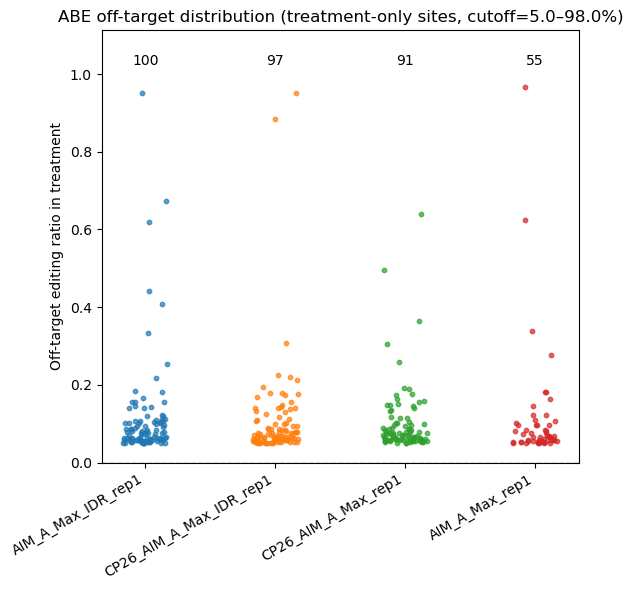

图已保存： offtarget_results/offtarget_jitterplot.png


In [13]:
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# =========================
# 配置
# =========================

DATA_DIR = Path("../results_RNA-seq/mut_tables")
OUT_DIR = Path("./offtarget_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

control_group = [
    "Control_rep1",
    "Control_rep2",
]

treatment_group = [
    "AIM_A_Max_IDR_rep1",
    "AIM_A_Max_rep1",
    "CP26_AIM_A_Max_IDR_rep1",
    "CP26_AIM_A_Max_rep1",
]

COVERAGE_MIN = 200  # coverage 下限

# 脱靶调用阈值：现在作用在 treatment 的 mut_ratio（不再做差值）
OFFTARGET_LOWER = 0.05
OFFTARGET_UPPER = 0.98

# HET 区间（作用在原始 treatment mut_ratio 上）
TREAT_HET_LOW = 0.497
TREAT_HET_HIGH = 0.503

BG_293T_PATH = Path("./bg_sites_293T.hg38.tsv.gz")
BG_GATK_PATH = Path("./bg_sites_GATKbundle.hg38.tsv.gz")

# =========================
# 1. 构建背景位点 MultiIndex (chr_name, chr_index)
# =========================

bg_indexes = []

# 293T 背景
p = BG_293T_PATH
df_bg = pd.read_csv(p, sep="\t", compression="gzip")
df_bg["chr"] = df_bg["chr"].astype(str)
df_bg["pos"] = df_bg["pos"].astype(int)
df_bg["chr_name"] = np.where(
    df_bg["chr"].str.startswith("chr"), df_bg["chr"], "chr" + df_bg["chr"]
)
df_bg["chr_index"] = df_bg["pos"].astype(int)
idx_bg = pd.MultiIndex.from_frame(df_bg[["chr_name", "chr_index"]])
bg_indexes.append(idx_bg)

# GATK 背景
p = BG_GATK_PATH
df_bg = pd.read_csv(p, sep="\t", compression="gzip")
df_bg["chr"] = df_bg["chr"].astype(str)
df_bg["pos"] = df_bg["pos"].astype(int)
df_bg["chr_name"] = np.where(
    df_bg["chr"].str.startswith("chr"), df_bg["chr"], "chr" + df_bg["chr"]
)
df_bg["chr_index"] = df_bg["pos"].astype(int)
idx_bg = pd.MultiIndex.from_frame(df_bg[["chr_name", "chr_index"]])
bg_indexes.append(idx_bg)

# 合并多个背景集合
bg_index = bg_indexes[0]
for idx_bg in bg_indexes[1:]:
    bg_index = bg_index.union(idx_bg)

# =========================
# 2. 读取所有 sample，做 ABE + 背景过滤 + coverage + mut_ratio
# =========================

core_tables = {}

for sample in control_group + treatment_group:
    in_path = DATA_DIR / f"{sample}.base_mut.filtered.tsv"
    df = pd.read_csv(in_path, sep="\t", dtype={"chr_name": str, "chr_index": int})

    # 去非核染色体
    df["chr_name"] = df["chr_name"].astype(str)
    mask_nuclear = ~df["chr_name"].str.match(r"^(chr)?(M|MT|Un|EBV)", case=False)
    df = df[mask_nuclear].copy()

    # ABE 定向：ref = A/T，mut_num 用 G/C
    mask_A = df["ref_base"] == "A"
    mask_T = df["ref_base"] == "T"
    df.loc[mask_A, "mut_num"] = df.loc[mask_A, "C"]  # A→G
    df.loc[mask_T, "mut_num"] = df.loc[mask_T, "G"]  # T→C
    df = df[mask_A | mask_T].copy()

    # 背景 SNP 过滤
    idx_tmp = pd.MultiIndex.from_frame(df[["chr_name", "chr_index"]])
    mask_keep = ~idx_tmp.isin(bg_index)
    df = df.loc[mask_keep].copy()

    # coverage + mut_ratio
    df["coverage"] = df[["A", "G", "C", "T", "del_count", "insert_count"]].sum(axis=1)
    df = df[df["coverage"] >= COVERAGE_MIN].copy()
    df = df[df["coverage"] > 0].copy()
    df["mut_ratio"] = df["mut_num"] / df["coverage"]

    core = df[["chr_name", "chr_index", "coverage", "mut_ratio"]].copy()
    core = core.set_index(["chr_name", "chr_index"]).sort_index()
    core_tables[sample] = core

control_core = OrderedDict((s, core_tables[s]) for s in control_group)
treat_core = OrderedDict((s, core_tables[s]) for s in treatment_group)

# =========================
# 3. Control 中“涉及过的位点”并集（mut_ratio > 0）
#    ——后面会把这些位点在 treatment 里全部丢掉
# =========================

control_any_idx = None
for s, core in control_core.items():
    idx_nonzero = core[core["mut_ratio"] > 0].index
    if control_any_idx is None:
        control_any_idx = idx_nonzero
    else:
        control_any_idx = control_any_idx.union(idx_nonzero)

# =========================
# 4. Treatment：先去 HET，再丢掉所有在 control 中出现过的位点
# =========================

treat_tables = OrderedDict()
for s, core in treat_core.items():
    tf = core.copy()

    # 去 HET 区间
    tf = tf[
        ~((tf["mut_ratio"] >= TREAT_HET_LOW) & (tf["mut_ratio"] <= TREAT_HET_HIGH))
    ].copy()

    # 丢掉所有 control 涉及的点
    if control_any_idx is not None:
        tf = tf[~tf.index.isin(control_any_idx)].copy()

    treat_tables[s] = tf

# =========================
# 5. union_idx = 所有 Treatment 的并集（treatment-only 位点）
# =========================

union_idx = None
for s, df_t in treat_tables.items():
    if union_idx is None:
        union_idx = df_t.index
    else:
        union_idx = union_idx.union(df_t.index)

if union_idx is None or len(union_idx) == 0:
    raise RuntimeError("所有 treatment 过滤后 union_idx 为空，请检查处理流程和阈值。")

# =========================
# 6. control_max 背景表（仅用于画图左侧背景分布）
#    由于对应位点都不在 control 中出现，理论上这里全是 0
# =========================

bg_max = pd.Series(0.0, index=union_idx, dtype=float)
for s, core in control_core.items():
    series = core.reindex(union_idx)["mut_ratio"].fillna(0.0)
    bg_max = pd.Series(
        np.maximum(bg_max.to_numpy(), series.to_numpy()), index=union_idx
    )

bg_df = pd.DataFrame({"bg_max_ratio": bg_max}, index=union_idx)

# =========================
# 7. offtarget_ratio：直接用 treatment 的 mut_ratio
# =========================

offtarget_tables = OrderedDict()
summary_rows = []

for s, tdf in treat_tables.items():
    idx_s = tdf.index
    t_use = tdf["mut_ratio"].to_numpy()
    bg_use = bg_df.reindex(idx_s)["bg_max_ratio"].fillna(0.0).to_numpy()

    offt = tdf["mut_ratio"].to_numpy()  # 核心：不再做差值

    merged = pd.DataFrame(
        {
            "mut_ratio": t_use,
            "bg_max_ratio": bg_use,
            "offtarget_ratio": offt,
        },
        index=idx_s,
    )

    call_mask = (merged["offtarget_ratio"] >= OFFTARGET_LOWER) & (
        merged["offtarget_ratio"] <= OFFTARGET_UPPER
    )

    offtarget_tables[s] = merged

    npos = int(call_mask.sum())
    summary_rows.append(
        {
            "sample": s,
            "n_offtarget_sites": npos,
            "median_offtarget_ratio": (
                float(merged.loc[call_mask, "offtarget_ratio"].median())
                if npos > 0
                else 0.0
            ),
            "mean_offtarget_ratio": (
                float(merged.loc[call_mask, "offtarget_ratio"].mean())
                if npos > 0
                else 0.0
            ),
            "total_sites_after_filters": int(len(idx_s)),
        }
    )

summary_df = pd.DataFrame(summary_rows).sort_values(
    "n_offtarget_sites", ascending=False
)

summary_path = OUT_DIR / "summary_offtarget_counts.tsv"
summary_df.to_csv(summary_path, sep="\t", index=False)
print("Summary 已保存：", summary_path)
print(summary_df)

# =========================
# 8. jitter plot 数据准备（只画 treatment）
# =========================

treat_order = summary_df["sample"].tolist()
samples_sorted = treat_order  # 不再加 Control_max_raw

data = []
counts = []

for name in samples_sorted:
    df_plot = offtarget_tables[name]
    # 只画通过 offtarget 调用阈值的点
    arr_full = df_plot.loc[
        (df_plot["offtarget_ratio"] >= OFFTARGET_LOWER)
        & (df_plot["offtarget_ratio"] <= OFFTARGET_UPPER),
        "offtarget_ratio",
    ].to_numpy()

    data.append(arr_full)
    counts.append(int(len(arr_full)))

# =========================
# 9. 画 jitter plot
# =========================

x = np.arange(len(samples_sorted))
plt.figure(figsize=(max(6, len(samples_sorted) * 1.2), 6))

for i, arr in enumerate(data):
    if len(arr) == 0:
        continue
    plot_arr = arr
    jitter = (np.random.rand(len(plot_arr)) - 0.5) * 0.35
    plt.scatter(np.full(len(plot_arr), x[i]) + jitter, plot_arr, s=10, alpha=0.7)

ymax = max([float(a.max()) for a in data if len(a) > 0], default=0.0)
for i, c in enumerate(counts):
    plt.text(
        x[i],
        ymax * 1.05 if ymax > 0 else 0.01,
        str(c),
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xticks(x, samples_sorted, rotation=30, ha="right")
plt.axhline(0, ls="--", lw=1)  # 可选：加一条 0 基线，表示 control 已经都是 0
plt.ylabel("Off-target editing ratio in treatment")
plt.title(
    f"ABE off-target distribution "
    f"(treatment-only sites, cutoff={OFFTARGET_LOWER * 100:.1f}–{OFFTARGET_UPPER * 100:.1f}%)"
)
if ymax > 0:
    plt.ylim(0, ymax * 1.15)

fig_path = OUT_DIR / "offtarget_jitterplot.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=180)
plt.show()
print("图已保存：", fig_path)